In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import calendar

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


#### Set config values

In [4]:
country="malawi"
config=Config()
parameters = config.parameters(country)
iso3=parameters["iso3_code"]
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,config.RAW_DIR,iso3)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR, config.PROCESSED_DIR,iso3)
country_data_exploration_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,"exploration",iso3)
data_exploration_dir= os.path.join(config.DATA_DIR, config.PUBLIC_DIR, "exploration")
chirps_monthly_dir=os.path.join(data_exploration_dir,"chirps")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [5]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Load dry spell data

In [6]:
df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","dry_spells_during_rainy_season_list_2000_2020_mean_back.csv")) 
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["ds_fd_m"]=df_ds.dry_spell_first_date.dt.to_period("M")

In [7]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,ds_fd_m
0,MW203,Ntchisi,2004,2005-03-08,2005-03-26,19,1.2,Central,2005-03
1,MW205,Salima,2004,2005-03-02,2005-03-26,25,1.6,Central,2005-03
2,MW209,Ntcheu,2004,2005-03-02,2005-03-25,24,1.7,Central,2005-03
3,MW302,Machinga,2004,2005-01-31,2005-02-13,14,1.0,Southern,2005-01
4,MW304,Chiradzulu,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008-02
5,MW304,Chiradzulu,2009,2010-01-01,2010-01-14,14,1.0,Southern,2010-01
6,MW304,Chiradzulu,2019,2020-02-26,2020-03-10,14,0.3,Southern,2020-02
7,MW305,Blantyre,2007,2008-02-10,2008-02-24,15,0.1,Southern,2008-02
8,MW305,Blantyre,2009,2010-01-01,2010-01-14,14,1.7,Southern,2010-01
9,MW305,Blantyre,2019,2020-02-26,2020-03-10,14,1.7,Southern,2020-02


In [8]:
#compute if start of dryspell per month-ADM2
#for now only want to know if a dry spell occured in a given month, so drop those that have several dry spells confirmed within a month
df_ds_drymonth=df_ds.drop_duplicates(["ADM2_EN","ds_fd_m"]).groupby(["ds_fd_m","ADM2_EN"],as_index=False).agg("count")[["ds_fd_m","ADM2_EN","dry_spell_first_date"]]

### Total monthly vs dry spells

In [9]:
#dataframe that includes all month-adm2 combinations that experienced a dry spell 
#(if several dry spells started within a month in an adm2, these "duplicates" are dropped)
df_ds_drymonth.head()

,ds_fd_m,ADM2_EN,dry_spell_first_date
0,2002-02,Nsanje,1
1,2004-03,Nsanje,1
2,2005-01,Chikwawa,1
3,2005-01,Machinga,1
4,2005-01,Mwanza,1


In [10]:
df_total_month=pd.read_csv(os.path.join(country_data_processed_dir,"chirps","seasonal","chirps_monthly_total_precipitation.csv"))
#remove day part of date (day doesnt indicate anything with this data and easier for merge)
df_total_month.date_month=pd.to_datetime(df_total_month.date_month).dt.to_period("M")

In [11]:
#path to data start and end rainy season
df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020_mean.csv"))
df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [12]:
#set the onset and cessation date for the seasons where these are missing 
#(meaning there was no dry spell data from start/till end of the season)
df_rain_filled=df_rain.copy()
df_rain_filled=df_rain_filled[(df_rain_filled.onset_date.notnull())|(df_rain_filled.cessation_date.notnull())]
df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

In [13]:
df_rain_filled["onset_month"]=df_rain_filled["onset_date"].dt.to_period("M")
df_rain_filled["cessation_month"]=df_rain_filled["cessation_date"].dt.to_period("M")

In [14]:
#remove the adm2-date entries outside the rainy season for that specific adm2
#df_belowavg_month only includes data from 2000, so the 1999 entries are not included
list_hist_rain_adm2=[]
for a in df_rain_filled.ADM2_EN.unique():
    dates_adm2=pd.Index([])
    for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
        df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
        seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="M")
        dates_adm2=dates_adm2.union(seas_range)
    list_hist_rain_adm2.append(df_total_month[(df_total_month.ADM2_EN==a)&(df_total_month.date_month.isin(dates_adm2))])
df_total_month_rain=pd.concat(list_hist_rain_adm2)

In [15]:
#include all dates present in the observed rainfall df but not in the dry spell list, i.e. where no dryspells were observed, by merging outer
df_comb_month=df_ds_drymonth.merge(df_total_month_rain,how="outer",left_on=['ADM2_EN','ds_fd_m'],right_on=["ADM2_EN","date_month"])

In [16]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_comb_month.dry_spell_first_date=df_comb_month.dry_spell_first_date.replace(np.nan,0)
#date becomes binary
df_comb_month.rename(columns={"dry_spell_first_date":"dry_spell"},inplace=True)

In [17]:
df_comb_month["month"]=df_comb_month.date_month.dt.month

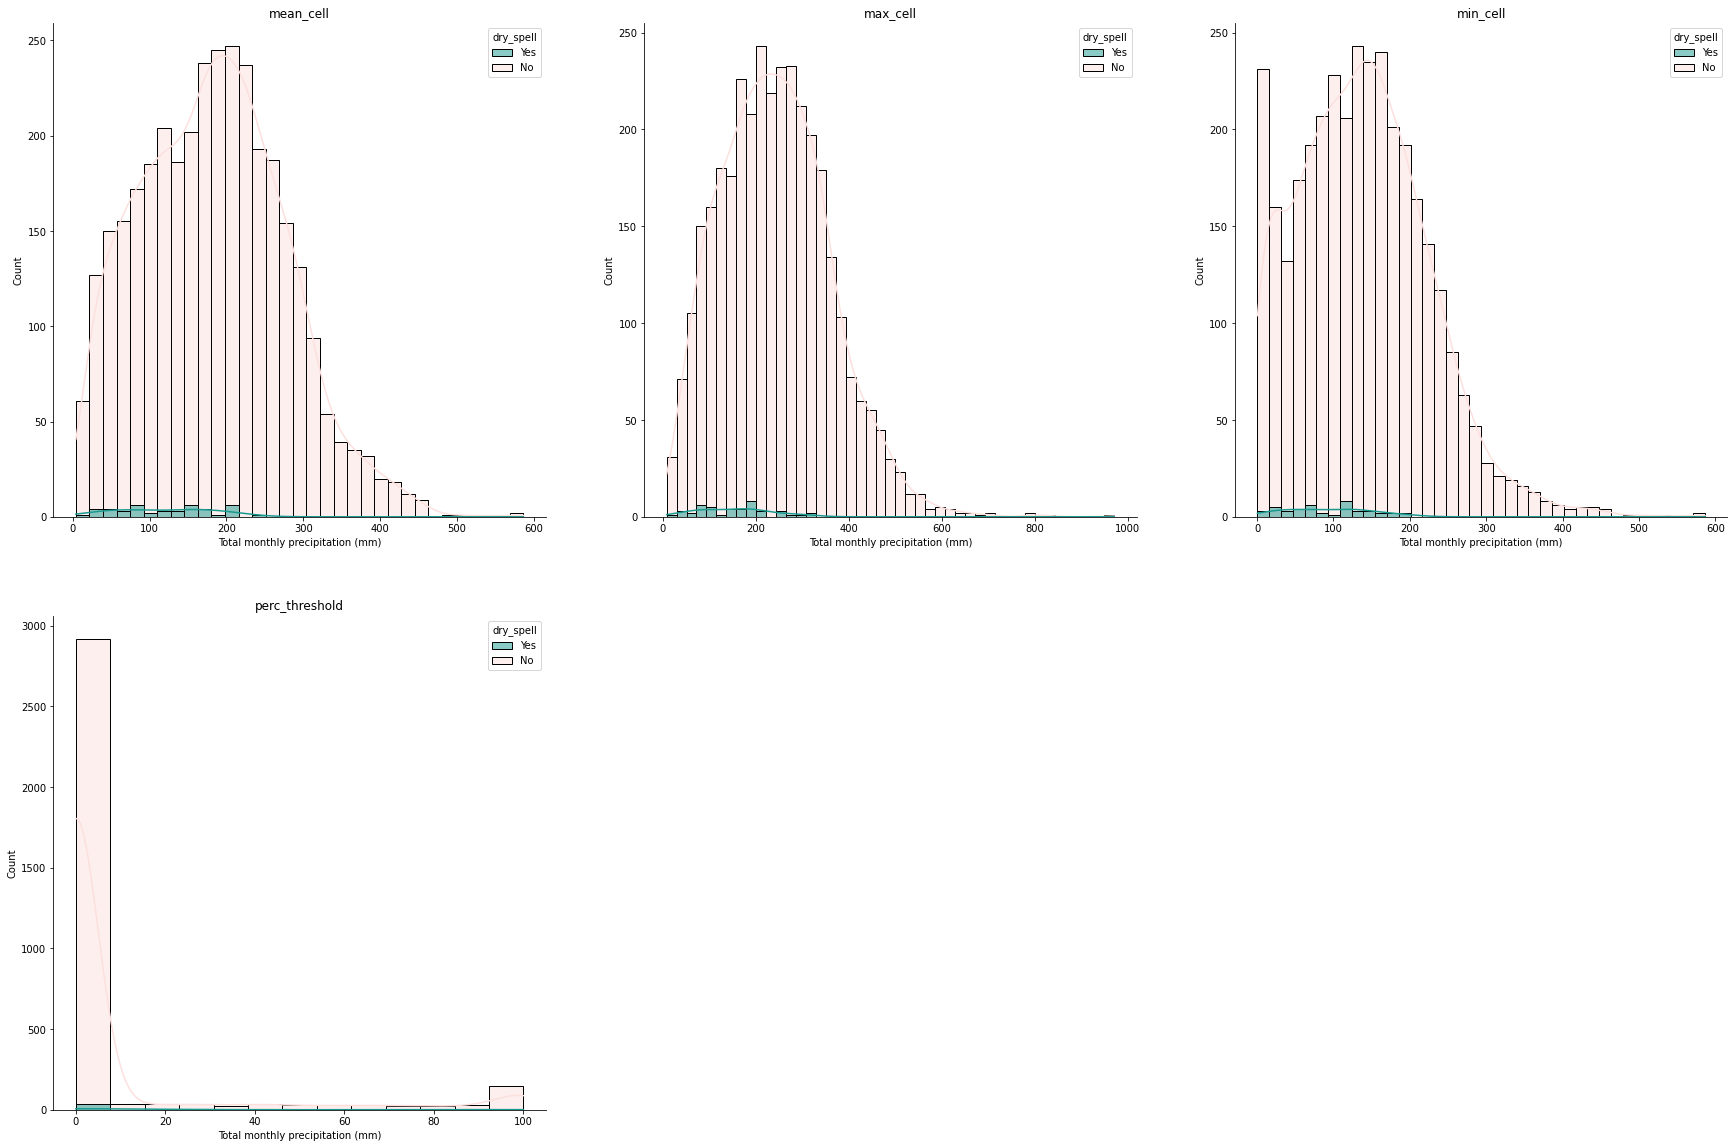

In [18]:
df_comb_month_labels=df_comb_month.replace({"dry_spell":{0:"No",1:"Yes"}})
cg_stats=["mean_cell","max_cell","min_cell","perc_threshold"]
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb_month_labels,x=s,ax=ax,stat="count",kde=True,hue="dry_spell",palette=["#18998F","#FCE0DE"])
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Total monthly precipitation (mm)")

In [19]:
len(df_comb_month)

3436

In [20]:
df_comb_month_sel=df_comb_month[df_comb_month.month.isin(df_comb_month[df_comb_month.dry_spell==1].month.unique())]

In [21]:
len(df_comb_month_sel)

2627

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


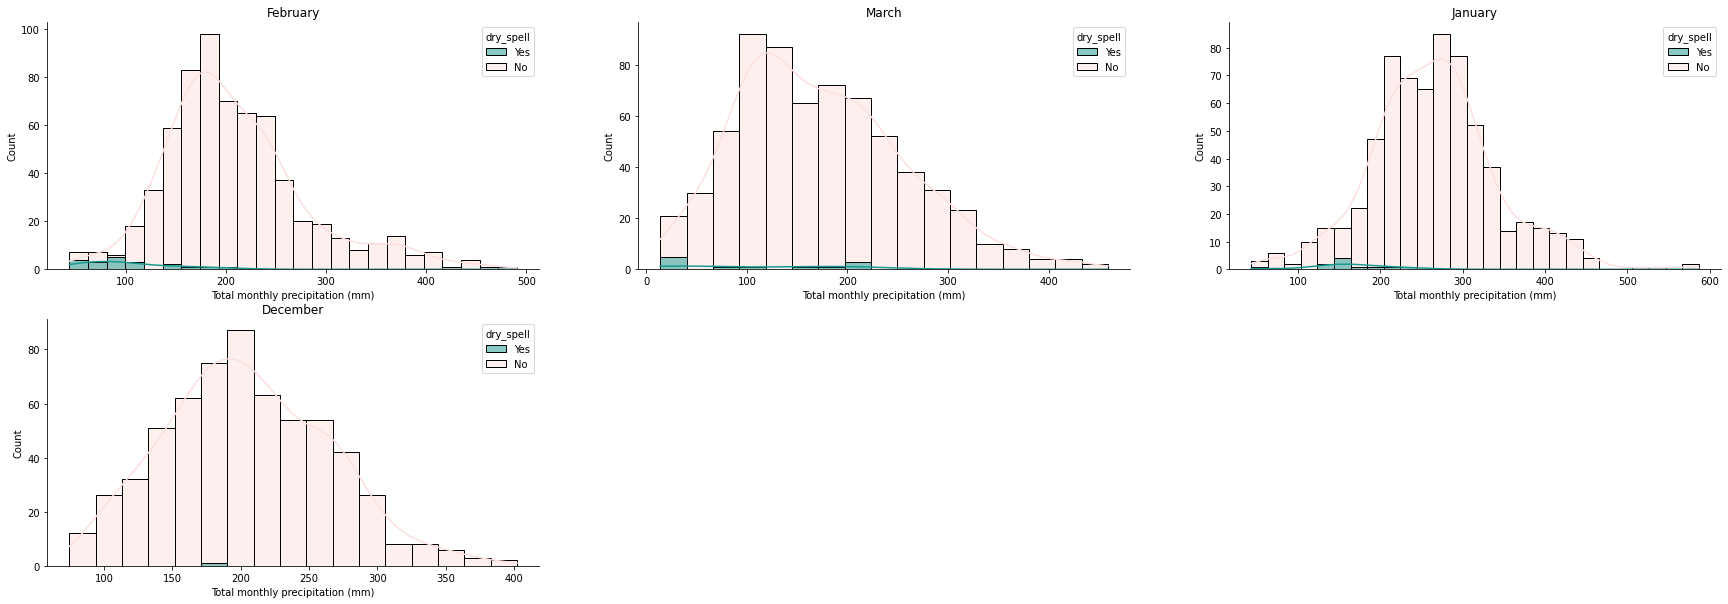

In [22]:
df_comb_month_sel_labels=df_comb_month_sel.replace({"dry_spell":{0:"No",1:"Yes"}})
cg_stats=df_comb_month_sel.month.unique()#["mean_cell","max_cell","min_cell"]#,"perc_threshold"]
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,10))
for i, s in enumerate(cg_stats):
    df_comb_month_sel_labels_s=df_comb_month_sel_labels[df_comb_month_sel_labels.month==s]
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb_month_sel_labels_s.sort_values("dry_spell",ascending=False),x="mean_cell",ax=ax,stat="count",kde=True,hue="dry_spell",palette=["#18998F","#FCE0DE"])
    ax.set_title(calendar.month_name[s])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Total monthly precipitation (mm)")

hit rate January: 9.1% (1/11)
miss rate January: 91.7% (11/12)
hit rate February: 60.0% (12/20)
miss rate February: 62.5% (20/32)
hit rate March: 50.0% (6/12)
miss rate March: 95.4% (125/131)
hit rate December: 0.0% (0/1)
miss rate December: 100.0% (17/17)


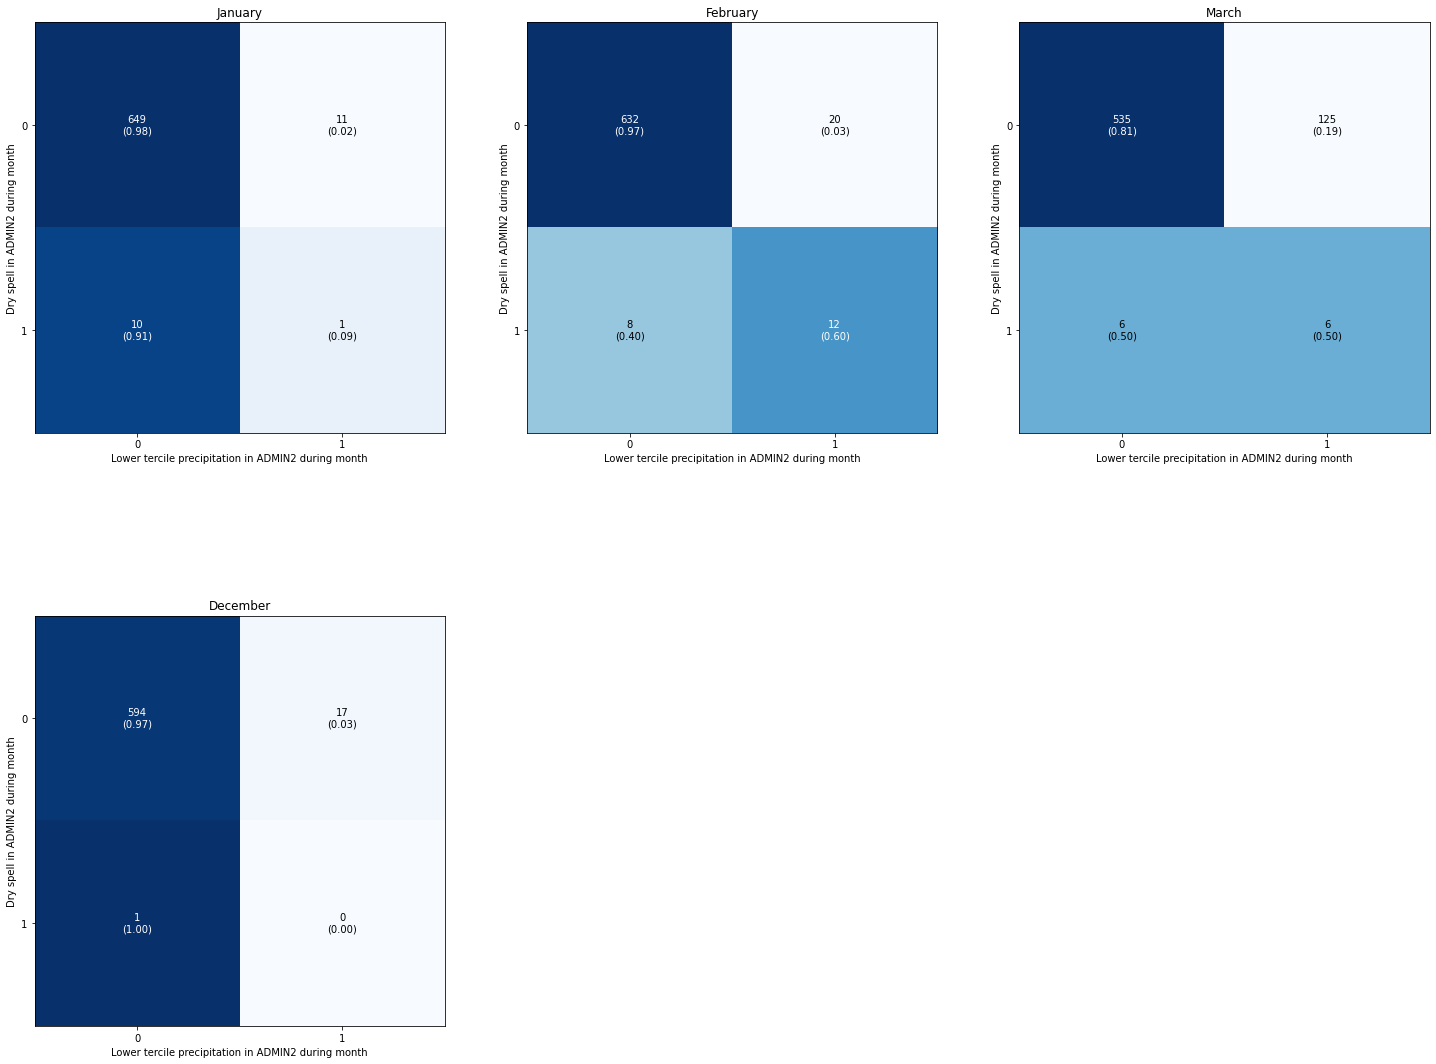

In [23]:
#check if difference per season
colp_num=3
num_plots=len(df_comb_month_sel.date_month.dt.month.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,m in enumerate(df_comb_month_sel.sort_values(by="date_month").date_month.dt.month.unique()):
    y_target =    df_comb_month_sel.loc[df_comb_month_sel.date_month.dt.month==m,"dry_spell"]
    y_predicted = y_predicted=np.where( df_comb_month_sel.loc[df_comb_month_sel.date_month.dt.month==m,"mean_cell"]<=100,1,0)
    
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    tn,fp,fn,tp=cm.flatten()
    print(f"hit rate {calendar.month_name[m]}: {round(tp/(tp+fn)*100,1)}% ({tp}/{tp+fn})")
    print(f"miss rate {calendar.month_name[m]}: {round(fp/(tp+fp)*100,1)}% ({fp}/{tp+fp})")
    ax = fig.add_subplot(rows,colp_num,i+1)
    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax)
    ax.set_ylabel("Dry spell in ADMIN2 during month")
    ax.set_xlabel("Lower tercile precipitation in ADMIN2 during month")
    ax.set_title(calendar.month_name[m])

In [24]:
df_ds.groupby("start_month").count()

KeyError: 'start_month'

In [26]:
df_feb=df_comb_month_sel[df_comb_month_sel.month==2]

In [27]:
y_target =  df_feb.dry_spell
threshold_list=np.arange(df_feb.mean_cell.min() - df_feb.mean_cell.min()%10,df_feb.mean_cell.max() - df_feb.mean_cell.max()%10,10)
df_pr=pd.DataFrame(threshold_list,columns=["threshold"]).set_index('threshold')
for t in threshold_list:
    y_predicted = np.where(df_feb.mean_cell<=t,1,0)

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    tn,fp,fn,tp=cm.flatten()
#     print(f"hit rate {t}mm: {round(tp/(tp+fn)*100,1)}% ({tp}/{tp+fn})")
#     print(f"miss rate {t}mm: {round(fp/(tp+fp)*100,1)}% ({fp}/{tn+fp})")
    df_pr.loc[t,["hit rate","miss rate"]]=tp/(tp+fn)*100,fp/(tp+fp)*100

<ipython-input-27-ba03bacff457>:12: RuntimeWarning: invalid value encountered in long_scalars
  df_pr.loc[t,["hit rate","miss rate"]]=tp/(tp+fn)*100,fp/(tp+fp)*100


Text(0.5, 1.0, 'Hit and miss rate for monthly precipitation during February')

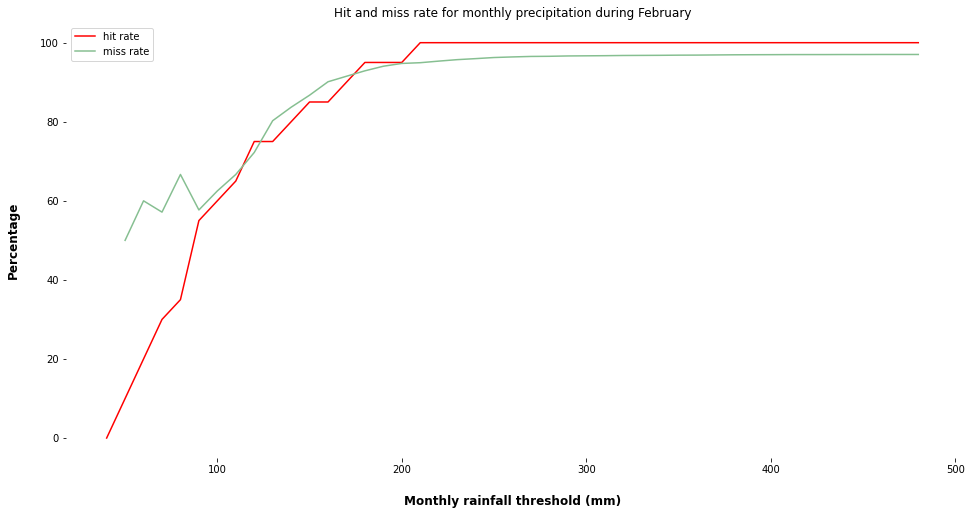

In [168]:
#plot timeseries for one adm2
#can see that trends are similair, but there are large differences, especially for the points of our interested, i.e. when observed <=2mm
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_pr=df_pr.reset_index()
df_pr.plot(x="threshold",y="hit rate" ,figsize=(16, 8), color='red',legend=True,ax=ax,label="hit rate")
df_pr.plot(x="threshold",y="miss rate" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax,label="miss rate")

# Set x-axis label
ax.set_xlabel("Monthly rainfall threshold (mm)", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Percentage", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Hit and miss rate for monthly precipitation during February")

<ipython-input-325-bbc7553d9bbc>:12: RuntimeWarning: invalid value encountered in long_scalars
  df_pr.loc[t,["hit_rate","miss_rate"]]=tp/(tp+fn)*100,fp/(tp+fp)*100


hit rate 100.0mm: 43.2% (19/44)
miss rate 100.0mm: 90.1% (173/192)
hit rate 200.0mm: 88.6% (39/44)
miss rate 200.0mm: 96.8% (1182/1221)


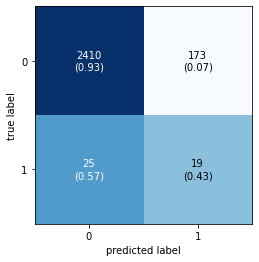

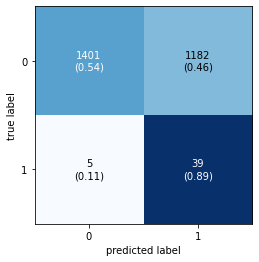

In [325]:
y_target =  df_comb_month_sel.dry_spell
threshold_list=np.arange(df_comb_month_sel.mean_cell.min() - df_comb_month_sel.mean_cell.min()%10,df_comb_month_sel.mean_cell.max() - df_comb_month_sel.mean_cell.max()%10,10)
df_pr=pd.DataFrame(threshold_list,columns=["threshold"]).set_index('threshold')
for t in threshold_list:
    y_predicted = np.where(df_comb_month_sel.mean_cell<=t,1,0)

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    tn,fp,fn,tp=cm.flatten()
#     print(f"hit rate {t}mm: {round(tp/(tp+fn)*100,1)}% ({tp}/{tp+fn})")
#     print(f"miss rate {t}mm: {round(fp/(tp+fp)*100,1)}% ({fp}/{tn+fp})")
    df_pr.loc[t,["hit_rate","miss_rate"]]=tp/(tp+fn)*100,fp/(tp+fp)*100
    #this doesn't really work to compute optimum threshold
#     df_pr.loc[t,"hit_miss"]=df_pr.loc[t,"hit_rate"]+(100-df_pr.loc[t,"miss_rate"])
    if t==100 or t==200:
        print(f"hit rate {t}mm: {round(tp/(tp+fn)*100,1)}% ({tp}/{tp+fn})")
        print(f"miss rate {t}mm: {round(fp/(tp+fp)*100,1)}% ({fp}/{tp+fp})")
        plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True)

In [323]:
df_pr.loc[100]

hit_rate     43.181818
miss_rate    90.104167
Name: 100.0, dtype: float64

In [237]:
#### df_pr[df_pr.hit_miss==df_pr.hit_miss.max()]

Text(0.5, 1.0, 'Hit and miss rate for monthly precipitation')

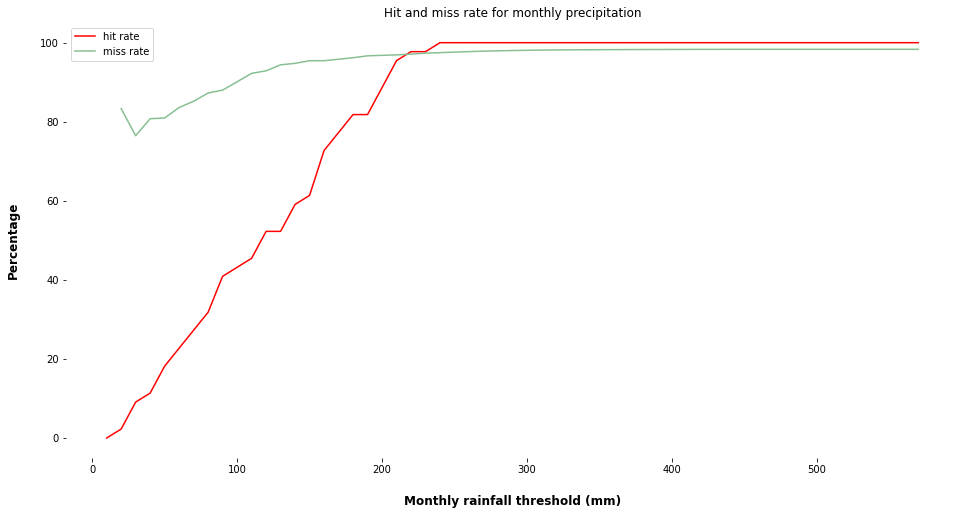

In [171]:
#plot timeseries for one adm2
#can see that trends are similair, but there are large differences, especially for the points of our interested, i.e. when observed <=2mm
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_pr=df_pr.reset_index()
df_pr.plot(x="threshold",y="hit rate" ,figsize=(16, 8), color='red',legend=True,ax=ax,label="hit rate")
df_pr.plot(x="threshold",y="miss rate" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax,label="miss rate")

# Set x-axis label
ax.set_xlabel("Monthly rainfall threshold (mm)", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Percentage", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Hit and miss rate for monthly precipitation")

In [228]:
t=100
df_feb["below_t"]=np.where(df_feb.mean_cell<=t,1,0)
df_numadm=df_feb.groupby("date_month").agg({"dry_spell":"sum","below_t":"sum"})#,"dry_spell":"count"})

<ipython-input-228-c174f4bae547>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feb["below_t"]=np.where(df_feb.mean_cell<=t,1,0)


In [319]:
df_numadm=df_comb_month_sel[df_comb_month_sel.mean_cell<=100].groupby("date_month").agg({"dry_spell":"sum","ADM2_EN":"count"})#,"dry_spell":"count"})

In [243]:
df_ds_res=df_ds.reset_index(drop=True)
a = [pd.date_range(*r, freq='D') for r in df_ds_res[['dry_spell_first_date', 'dry_spell_last_date']].values]
#join the daterange with the adm2, which create a column per date, then stack to have each adm2-date combination
df_ds_daterange=df_ds_res[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
df_ds_daterange.rename(columns={0:"date"},inplace=True)
#all dates in this dataframe had an observed dry spell, so add that information
df_ds_daterange["dryspell_obs"]=1

In [255]:
import itertools

In [258]:
df_daterange=pd.DataFrame(list(itertools.product(pd.date_range("2000-01-01","2020-12-31",freq="D"),df_ds.ADM2_EN.unique())),columns=['date','ADM2_EN'])

In [263]:
df_daterange_ds=df_daterange.merge(df_ds_daterange,on=["date","ADM2_EN"],how="left")

In [264]:
df_daterange_ds[df_daterange_ds.dryspell_obs==1]

,date,ADM2_EN,dryspell_obs
12507,2002-02-20,Nsanje,1.0
12523,2002-02-21,Nsanje,1.0
12539,2002-02-22,Nsanje,1.0
12555,2002-02-23,Nsanje,1.0
12571,2002-02-24,Nsanje,1.0
...,...,...,...
118070,2020-03-14,Chikwawa,1.0
118082,2020-03-15,Mwanza,1.0
118086,2020-03-15,Chikwawa,1.0
118098,2020-03-16,Mwanza,1.0


In [287]:
pd.to_datetime(df_comb_month.date)

0      2002-02-01
1      2004-03-01
2      2005-01-01
3      2005-01-01
4      2005-01-01
          ...    
3431   2019-11-01
3432   2019-12-01
3433   2020-01-01
3434   2020-03-01
3435   2020-12-01
Name: date, Length: 3436, dtype: datetime64[ns]

In [306]:
t=100
df_comb_month_be=df_comb_month[df_comb_month.mean_cell<=t]
df_comb_month_be["first_date"]=pd.to_datetime(df_comb_month_be.date)
df_comb_month_be["last_date"]=df_comb_month_be.date_month.dt.to_timestamp("M")
df_comb_month_be_res=df_comb_month_be.reset_index(drop=True)
a = [pd.date_range(*r, freq='D') for r in df_comb_month_be_res[['first_date', 'last_date']].values]
#join the daterange with the adm2, which create a column per date, then stack to have each adm2-date combination
df_precip_daterange=df_comb_month_be_res[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
df_precip_daterange.rename(columns={0:"date"},inplace=True)
#all dates in this dataframe had an observed dry spell, so add that information
df_precip_daterange["precip_below"]=1

<ipython-input-306-787649d24584>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_month_be["first_date"]=pd.to_datetime(df_comb_month_be.date)
<ipython-input-306-787649d24584>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_month_be["last_date"]=df_comb_month_be.date_month.dt.to_timestamp("M")


In [308]:
df_daterange_comb=df_daterange_ds.merge(df_precip_daterange,on=["date","ADM2_EN"],how="left")

In [310]:
df_daterange_comb.dryspell_obs=df_daterange_comb.dryspell_obs.replace(np.nan,0)
df_daterange_comb.precip_below=df_daterange_comb.precip_below.replace(np.nan,0)

In [311]:
def label_ds(row):
    if row["dryspell_obs"]==1 and row["precip_below"]==1:
        return 3
    elif row["dryspell_obs"]==1:
        return 2
    elif row["precip_below"]==1:
        return 1
    else:
        return 0

In [312]:
#encode dry spells and whether it was none, only observed, only forecasted, or both
df_daterange_comb["dryspell_match"]=df_daterange_comb.apply(lambda row:label_ds(row),axis=1)

In [316]:
df_adm2=gpd.read_file(adm2_bound_path)
df_daterange_comb=df_daterange_comb.merge(df_adm2[["ADM2_EN","ADM2_PCODE"]])
df_daterange_comb.rename(columns={"ADM2_PCODE":"pcode"},inplace=True)

In [317]:
df_daterange_comb.to_csv(os.path.join(country_data_processed_dir,"dry_spells","seasonal",f"monthly_dryspellobs_th100.csv"))

In [320]:
df_numadm[df_numadm.dry_spell==1]

,dry_spell,ADM2_EN
date_month,,
2018-01,1.0,12


<AxesSubplot:xlabel='dry_spell', ylabel='ADM2_EN'>

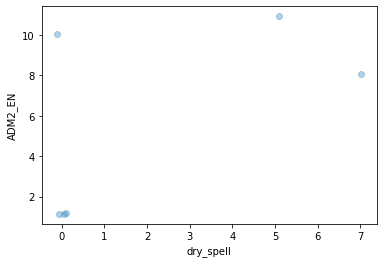

In [223]:
sns.regplot(data = df_numadm, x = 'dry_spell', y = 'ADM2_EN', fit_reg = False,
            scatter_kws = {'alpha' : 1/3},x_jitter = 0.2, y_jitter = 0.2)

### Seasonal

In [60]:
df_total_seas=pd.read_csv(os.path.join(country_data_processed_dir,"observed_belowavg_precip","chirps_seasonal_total_precipitation.csv"))
#remove day part of date (day doesnt indicate anything with this data and easier for merge)
df_total_seas.date_month=pd.to_datetime(df_total_seas.date_month).dt.to_period("M")

In [61]:
# #remove the adm2-date entries outside the rainy season for that specific adm2
# #df_total_seas only includes data from 2000, so the 1999 entries are not included
# list_hist_rain_adm2=[]
# for a in df_rain_filled.ADM2_EN.unique():
#     dates_adm2=pd.Index([])
#     for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
#         df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
#         seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="M")
#         dates_adm2=dates_adm2.union(seas_range)
#     list_hist_rain_adm2.append(df_total_seas[(df_total_seas.ADM2_EN==a)&(df_total_seas.date_month.isin(dates_adm2))])
# df_total_seas_rain=pd.concat(list_hist_rain_adm2)

In [62]:
df_total_seas_rain=df_total_seas.copy()

In [63]:
#include all dates present in the observed rainfall df but not in the dry spell list, i.e. where no dryspells were observed, by merging outer
df_ds_drymonth_rain=df_ds_drymonth.merge(df_total_seas_rain[["ADM2_EN","date_month"]],how="outer",left_on=['ADM2_EN','ds_fd_m'],right_on=["ADM2_EN","date_month"])

In [64]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_ds_drymonth_rain.dry_spell_first_date=df_ds_drymonth_rain.dry_spell_first_date.replace(np.nan,0)

In [65]:
#fill the data frame to include all months, also outside the rainy season --> this enables us to take the rolling sum 
#(else e.g. the rolling sum for Nov might include May-June-Nov)
df_ds_drymonth_alldates=df_ds_drymonth_rain.sort_values("date_month").set_index("date_month").groupby('ADM2_EN').resample('M').sum().drop("ADM2_EN",axis=1).reset_index()

In [66]:
#compute the rolling sum of months having a dry spell per admin2
s_ds_dryseas=df_ds_drymonth_alldates.sort_values("date_month").set_index("date_month").groupby('ADM2_EN')['dry_spell_first_date'].rolling(3).sum()
#convert series to dataframe
df_ds_dryseas=pd.DataFrame(s_ds_dryseas).reset_index().sort_values(["ADM2_EN","date_month"])
df_ds_dryseas.rename(columns={"dry_spell_first_date":"num_dry_spell_seas"},inplace=True)

In [67]:
#merge the dry spells with the info if a month had below average rainfall
#merge on right such that only the dates within the rainy season are included, df_ds_dryseas also includes all other months
df_comb_seas=df_ds_dryseas.merge(df_total_seas_rain,how="right",on=["date_month","ADM2_EN"])

In [68]:
#remove dates where dry_spell_confirmation is nan, i.e. where rolling sum could not be computed for (first dates)
df_comb_seas=df_comb_seas[df_comb_seas.num_dry_spell_seas.notna()]

In [69]:
#set the occurence of a dry spell to true if in at least one of the months of the season (=3 months) a dry spell occured
df_comb_seas["dry_spell"]=np.where(df_comb_seas.num_dry_spell_seas>=1,1,0)

In [70]:
df_comb_seas["month"]=df_comb_seas.date_month.dt.month

In [87]:
df_comb_seas[(df_comb_seas.dry_spell==1)&(df_comb_seas.date_month.dt.month==4)]

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,date,validOn,validTo,perc_threshold,max_cell,mean_cell,min_cell,date_str,dry_spell,month
869,Nsanje,2002-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2002-04-01,2018-10-16,NaN,0.0,485.121460,304.212617,192.990700,2002-04,1,4
1636,Nsanje,2004-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2004-04-01,2018-10-16,NaN,0.0,516.155380,336.099720,207.252125,2004-04,1,4
2023,Ntchisi,2005-04,1.0,2.085826,0.143596,MW203,NaN,NaN,NaN,Central,...,2005-04-01,2018-10-16,NaN,0.0,368.229584,300.513711,240.243067,2005-04,1,4
2025,Salima,2005-04,1.0,2.739096,0.179292,MW205,NaN,NaN,NaN,Central,...,2005-04-01,2018-10-16,NaN,0.0,286.601868,203.918521,157.139441,2005-04,1,4
2029,Ntcheu,2005-04,1.0,3.135728,0.273175,MW209,NaN,NaN,NaN,Central,...,2005-04-01,2018-10-16,NaN,0.0,238.126881,157.144791,96.452521,2005-04,1,4
2031,Zomba City,2005-04,1.0,0.295003,0.003375,MW314,NaN,NaN,NaN,Southern,...,2005-04-01,2018-10-16,NaN,0.0,210.203365,210.203365,210.203365,2005-04,1,4
3168,Mwanza,2008-04,1.0,1.378986,0.058816,MW306,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,226.433134,174.119244,137.829705,2008-04,1,4
3171,Neno,2008-04,1.0,2.553469,0.136825,MW313,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,288.382282,187.012194,134.060804,2008-04,1,4
3175,Phalombe,2008-04,1.0,1.777164,0.119761,MW309,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,404.362820,252.335895,185.309692,2008-04,1,4
3179,Thyolo,2008-04,1.0,1.942617,0.140880,MW307,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,283.792288,233.249921,193.401541,2008-04,1,4


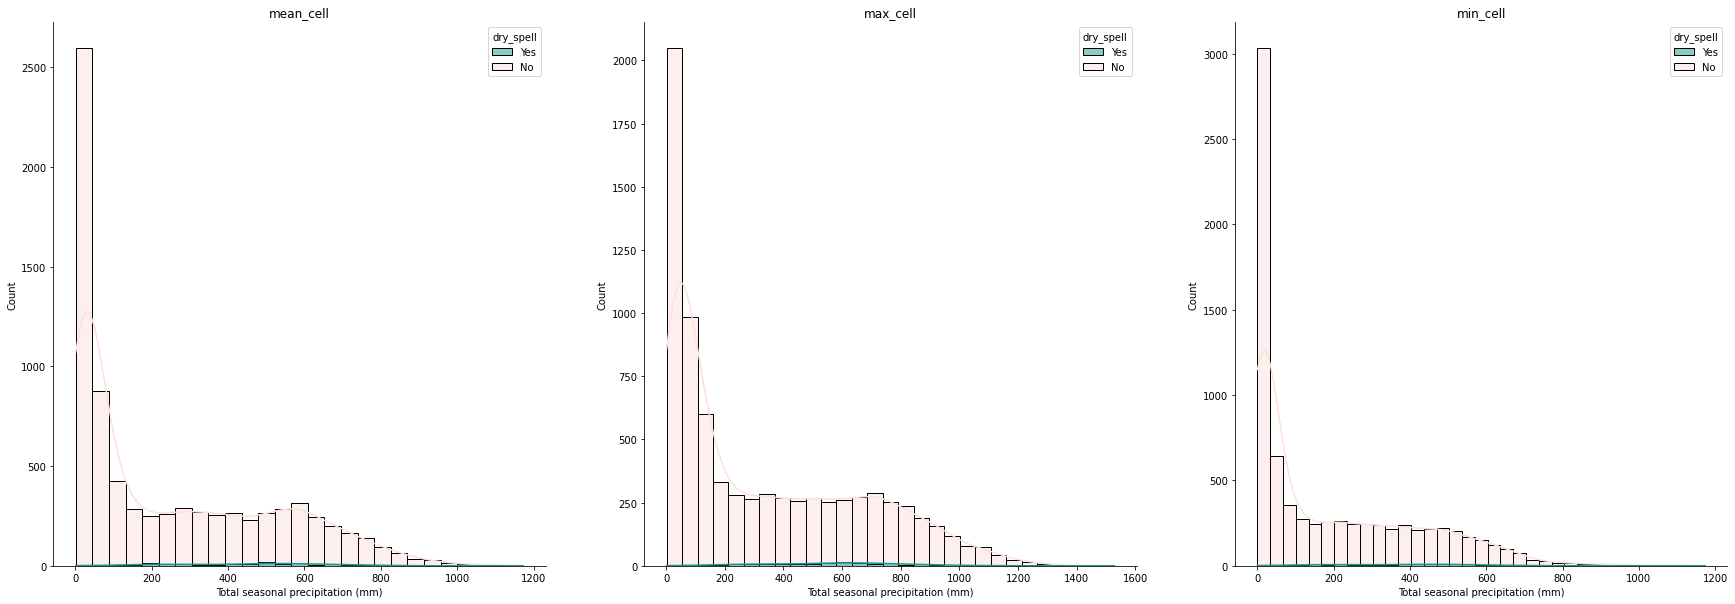

In [72]:
df_comb_seas_labels=df_comb_seas.replace({"dry_spell":{0:"No",1:"Yes"}})
cg_stats=["mean_cell","max_cell","min_cell"]#,"perc_threshold"]
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,10))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb_seas_labels.sort_values("dry_spell",ascending=False),x=s,ax=ax,stat="count",kde=True,hue="dry_spell",palette=["#18998F","#FCE0DE"])
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Total seasonal precipitation (mm)")

In [89]:
df_comb_seas_sel=df_comb_seas[df_comb_seas.month.isin(df_comb_seas[df_comb_seas.dry_spell==1].month.unique())]

In [90]:
df_comb_seas_sel[(df_comb_seas_sel.dry_spell==1)&(df_comb_seas_sel.date_month.dt.month==4)]

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,date,validOn,validTo,perc_threshold,max_cell,mean_cell,min_cell,date_str,dry_spell,month
869,Nsanje,2002-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2002-04-01,2018-10-16,NaN,0.0,485.121460,304.212617,192.990700,2002-04,1,4
1636,Nsanje,2004-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2004-04-01,2018-10-16,NaN,0.0,516.155380,336.099720,207.252125,2004-04,1,4
2023,Ntchisi,2005-04,1.0,2.085826,0.143596,MW203,NaN,NaN,NaN,Central,...,2005-04-01,2018-10-16,NaN,0.0,368.229584,300.513711,240.243067,2005-04,1,4
2025,Salima,2005-04,1.0,2.739096,0.179292,MW205,NaN,NaN,NaN,Central,...,2005-04-01,2018-10-16,NaN,0.0,286.601868,203.918521,157.139441,2005-04,1,4
2029,Ntcheu,2005-04,1.0,3.135728,0.273175,MW209,NaN,NaN,NaN,Central,...,2005-04-01,2018-10-16,NaN,0.0,238.126881,157.144791,96.452521,2005-04,1,4
2031,Zomba City,2005-04,1.0,0.295003,0.003375,MW314,NaN,NaN,NaN,Southern,...,2005-04-01,2018-10-16,NaN,0.0,210.203365,210.203365,210.203365,2005-04,1,4
3168,Mwanza,2008-04,1.0,1.378986,0.058816,MW306,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,226.433134,174.119244,137.829705,2008-04,1,4
3171,Neno,2008-04,1.0,2.553469,0.136825,MW313,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,288.382282,187.012194,134.060804,2008-04,1,4
3175,Phalombe,2008-04,1.0,1.777164,0.119761,MW309,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,404.362820,252.335895,185.309692,2008-04,1,4
3179,Thyolo,2008-04,1.0,1.942617,0.140880,MW307,NaN,NaN,NaN,Southern,...,2008-04-01,2018-10-16,NaN,0.0,283.792288,233.249921,193.401541,2008-04,1,4


In [74]:
threshold_list=[300,400,600,800,1000]
df_pr=pd.DataFrame(threshold_list,columns=["threshold"]).set_index('threshold')
for t in threshold_list:
    y_predicted=np.where(df_comb_seas_sel["mean_cell"]<=t,1,0)
    y_target =    df_comb_seas_sel["dry_spell"]
#y_predicted = df_comb_seas["precip_se200"]
    print(confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted))
    print(confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted).flatten())
    df_pr.loc[t,["tn","fp","fn","tp"]]=confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted).flatten()

[[2902  934]
 [  95   37]]
[2902  934   95   37]
[[2304 1532]
 [  83   49]]
[2304 1532   83   49]
[[1064 2772]
 [  30  102]]
[1064 2772   30  102]
[[ 221 3615]
 [   1  131]]
[ 221 3615    1  131]
[[  21 3815]
 [   0  132]]
[  21 3815    0  132]


In [91]:
seasons_rolling={3:"JFM",4:"FMA",5:"MAM",6:"AMJ",7:"MJJ",8:"JJA",9:"JAS",10:"ASO",12:"SON",12:"OND",1:"NDJ",2:"DJF"}

In [92]:
df_comb_seas_sel["season_abbr"]=df_comb_seas_sel.month.map(seasons_rolling)

<ipython-input-92-5ffbd3d219bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_seas_sel["season_abbr"]=df_comb_seas_sel.month.map(seasons_rolling)


In [93]:
df_comb_seas_sel[(df_comb_seas_sel.dry_spell==1)&(df_comb_seas_sel.season_abbr=="FMA")]

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,validOn,validTo,perc_threshold,max_cell,mean_cell,min_cell,date_str,dry_spell,month,season_abbr
869,Nsanje,2002-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,485.121460,304.212617,192.990700,2002-04,1,4,FMA
1636,Nsanje,2004-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,516.155380,336.099720,207.252125,2004-04,1,4,FMA
2023,Ntchisi,2005-04,1.0,2.085826,0.143596,MW203,NaN,NaN,NaN,Central,...,2018-10-16,NaN,0.0,368.229584,300.513711,240.243067,2005-04,1,4,FMA
2025,Salima,2005-04,1.0,2.739096,0.179292,MW205,NaN,NaN,NaN,Central,...,2018-10-16,NaN,0.0,286.601868,203.918521,157.139441,2005-04,1,4,FMA
2029,Ntcheu,2005-04,1.0,3.135728,0.273175,MW209,NaN,NaN,NaN,Central,...,2018-10-16,NaN,0.0,238.126881,157.144791,96.452521,2005-04,1,4,FMA
2031,Zomba City,2005-04,1.0,0.295003,0.003375,MW314,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,210.203365,210.203365,210.203365,2005-04,1,4,FMA
3168,Mwanza,2008-04,1.0,1.378986,0.058816,MW306,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,226.433134,174.119244,137.829705,2008-04,1,4,FMA
3171,Neno,2008-04,1.0,2.553469,0.136825,MW313,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,288.382282,187.012194,134.060804,2008-04,1,4,FMA
3175,Phalombe,2008-04,1.0,1.777164,0.119761,MW309,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,404.362820,252.335895,185.309692,2008-04,1,4,FMA
3179,Thyolo,2008-04,1.0,1.942617,0.140880,MW307,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,283.792288,233.249921,193.401541,2008-04,1,4,FMA


/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


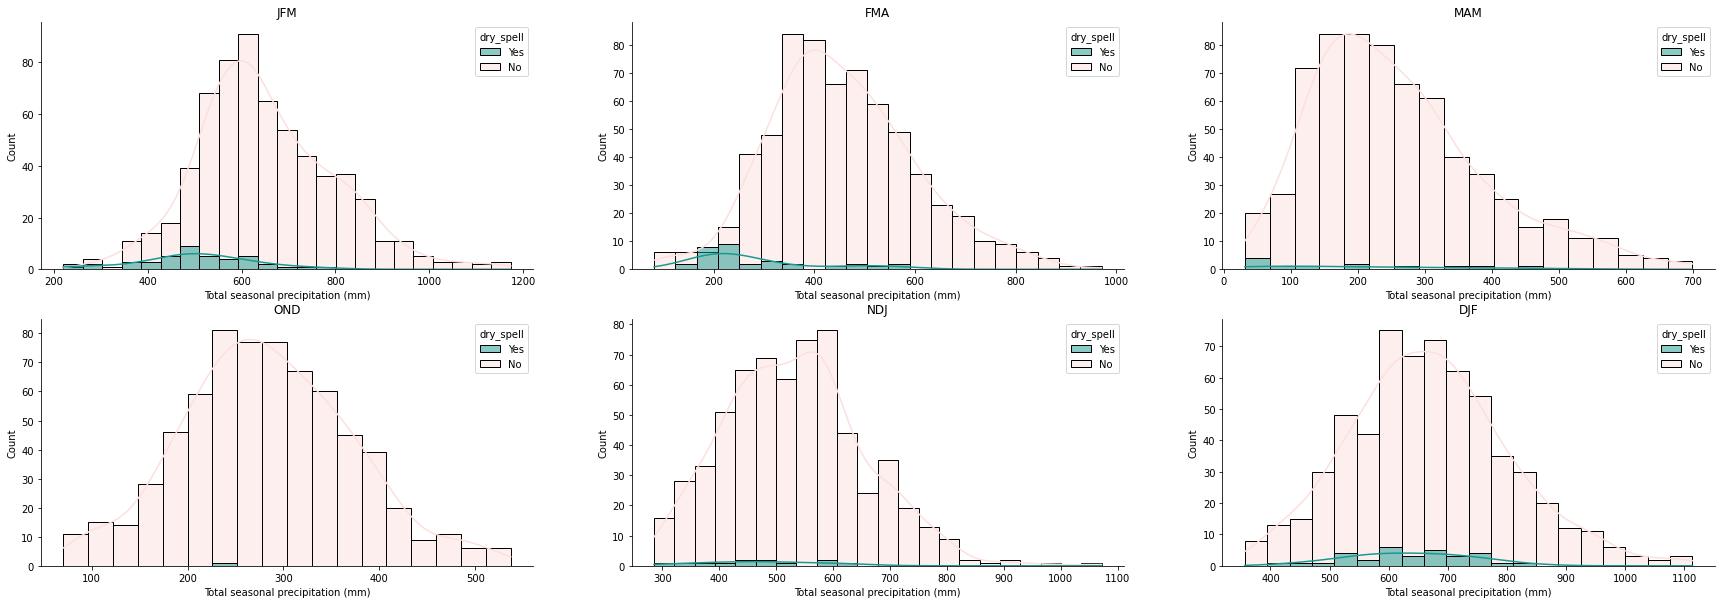

In [78]:
df_comb_seas_sel_labels=df_comb_seas_sel.replace({"dry_spell":{0:"No",1:"Yes"}})
cg_stats=df_comb_seas_sel.season_abbr.unique()#["mean_cell","max_cell","min_cell"]#,"perc_threshold"]
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,10))
for i, s in enumerate(cg_stats):
    df_comb_seas_sel_labels_s=df_comb_seas_sel_labels[df_comb_seas_sel_labels.season_abbr==s]
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb_seas_sel_labels_s.sort_values("dry_spell",ascending=False),x="mean_cell",ax=ax,stat="count",kde=True,hue="dry_spell",palette=["#18998F","#FCE0DE"])
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Total seasonal precipitation (mm)")

In [123]:
df_ds["year"]=df_ds.dry_spell_first_date.dt.year

In [128]:
df_ds.groupby("season_approx").count()

,pcode,ADM2_EN,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,ds_fd_m,start_month,year
season_approx,,,,,,,,,,
2001,1,1,1,1,1,1,1,1,1,1
2003,1,1,1,1,1,1,1,1,1,1
2004,9,9,9,9,9,9,9,9,9,9
2007,10,10,10,10,10,10,10,10,10,10
2009,6,6,6,6,6,6,6,6,6,6
2010,6,6,6,6,6,6,6,6,6,6
2016,3,3,3,3,3,3,3,3,3,3
2017,3,3,3,3,3,3,3,3,3,3
2019,6,6,6,6,6,6,6,6,6,6


In [101]:
df_comb_seas_sel[(df_comb_seas_sel.season_abbr=="FMA")&(df_comb_seas_sel.mean_cell<=250)].groupby("date_month").agg({"dry_spell":["sum","count"]})

dry_spell      
                 sum count
date_month                
2005-04            3    23
2008-04            8    13
2011-04            4     6
2013-04            0     1
2016-04            0     1
2020-04            4     8

In [104]:
df_comb_seas_sel[(df_comb_seas_sel.season_abbr=="FMA")&(df_comb_seas_sel.dry_spell==1)&(df_comb_seas_sel.mean_cell>250)]#.groupby("date_month").agg({"dry_spell":["sum","count"]})

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,validOn,validTo,perc_threshold,max_cell,mean_cell,min_cell,date_str,dry_spell,month,season_abbr
869,Nsanje,2002-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,485.121460,304.212617,192.990700,2002-04,1,4,FMA
1636,Nsanje,2004-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,516.155380,336.099720,207.252125,2004-04,1,4,FMA
2023,Ntchisi,2005-04,1.0,2.085826,0.143596,MW203,NaN,NaN,NaN,Central,...,2018-10-16,NaN,0.0,368.229584,300.513711,240.243067,2005-04,1,4,FMA
3175,Phalombe,2008-04,1.0,1.777164,0.119761,MW309,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,404.362820,252.335895,185.309692,2008-04,1,4,FMA
3181,Mulanje,2008-04,1.0,2.677536,0.168737,MW308,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,434.993587,296.981579,188.277136,2008-04,1,4,FMA
4334,Mulanje,2011-04,1.0,2.677536,0.168737,MW308,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,780.161896,472.149739,217.005844,2011-04,1,4,FMA
6629,Nsanje,2017-04,1.0,2.975867,0.164336,MW311,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,670.804550,494.642983,322.620382,2017-04,1,4,FMA
6636,Zomba City,2017-04,1.0,0.295003,0.003375,MW314,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,522.460426,522.460426,522.460426,2017-04,1,4,FMA
6644,Blantyre City,2017-04,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,469.596828,437.576766,406.966778,2017-04,1,4,FMA
7019,Thyolo,2018-04,1.0,1.942617,0.140880,MW307,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.0,742.127716,580.140234,442.786934,2018-04,1,4,FMA


In [115]:
33/(19+33)

0.6346153846153846

In [116]:
19/(19+13)

0.59375

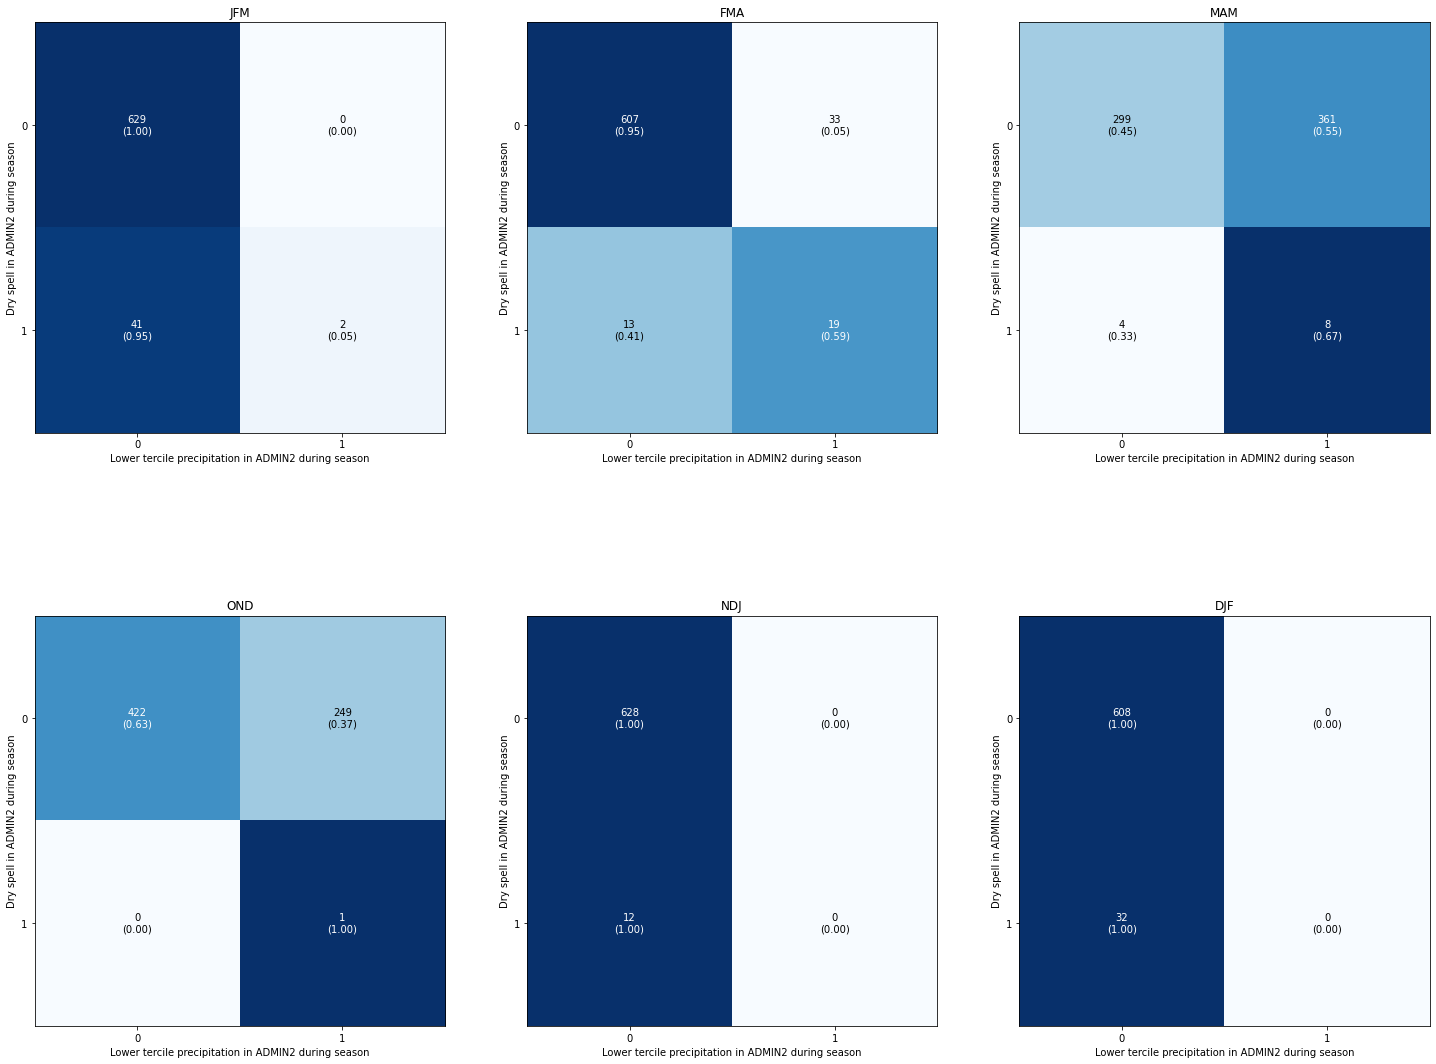

In [94]:
#check if difference per season
colp_num=3
num_plots=len(df_comb_seas_sel.season_abbr.unique())
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,m in enumerate(df_comb_seas_sel.season_abbr.unique()):
    y_target =    df_comb_seas_sel.loc[df_comb_seas_sel.season_abbr==m,"dry_spell"]
    y_predicted = np.where( df_comb_seas_sel.loc[df_comb_seas_sel.season_abbr==m,"mean_cell"]<=250,1,0)

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    ax = fig.add_subplot(rows,colp_num,i+1)
    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax)
    ax.set_ylabel("Dry spell in ADMIN2 during season")
    ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
    ax.set_title(m)

In [33]:
# df_pr.to_csv(os.path.join(country_data_processed_dir,"dry_spells","seasonal",f"seasonal_confusionmatrix_thresholds.csv"))

In [130]:
df_pr

,tn,fp,fn,tp,ratio_hit,ratio_miss
threshold,,,,,,
300,1920.0,22.0,82.0,9.0,0.290323,0.901099
400,1791.0,151.0,76.0,15.0,0.090361,0.835165
600,1011.0,931.0,30.0,61.0,0.061492,0.329670
800,219.0,1723.0,1.0,90.0,0.049641,0.010989
1000,21.0,1921.0,0.0,91.0,0.045229,0.000000


In [126]:
15/(151+15)

0.09036144578313253

In [129]:
df_pr["ratio_hit"]=df_pr["tp"]/(df_pr["tp"]+df_pr["fp"])
df_pr["ratio_miss"]=df_pr["fn"]/(df_pr["fn"]+df_pr["tp"])

In [ ]:
per seas
num with and without dry spells

In [111]:
y_predicted=np.where(df_comb_seas_sel["mean_cell"]<=500,1,0)
y_target =    df_comb_seas_sel["dry_spell"]
tn,fp,fn,tp=confusion_matrix(y_target=y_target, 
                  y_predicted=y_predicted).flatten()

In [109]:
df_comb_seas_sel

,ADM2_EN,date_month,num_dry_spell_seas,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,date,validOn,validTo,perc_threshold,max_cell,mean_cell,min_cell,date_str,dry_spell,month
2,Chitipa,2000-03,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2000-03-01,2018-10-16,NaN,0.0,665.144302,551.717012,441.426010,2000-03,0,3
3,Chitipa,2000-04,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2000-04-01,2018-10-16,NaN,0.0,745.060196,532.558693,371.703621,2000-04,0,4
6,Chitipa,2001-01,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2001-01-01,2018-10-16,NaN,0.0,873.329773,711.375023,555.473129,2001-01,0,1
7,Chitipa,2001-02,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2001-02-01,2018-10-16,NaN,0.0,807.975708,673.264852,489.730850,2001-02,0,2
8,Chitipa,2001-03,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2001-03-01,2018-10-16,NaN,0.0,766.545914,612.482633,493.888260,2001-03,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,Blantyre City,2019-03,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2019-03-01,2018-10-16,NaN,0.0,726.770782,690.758429,640.786255,2019-03,0,3
3429,Blantyre City,2019-04,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2019-04-01,2018-10-16,NaN,0.0,465.541550,441.638983,407.847733,2019-04,0,4
3432,Blantyre City,2020-01,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2020-01-01,2018-10-16,NaN,0.0,539.350327,508.891480,485.473076,2020-01,0,1
3433,Blantyre City,2020-02,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2020-02-01,2018-10-16,NaN,0.0,644.936401,604.693841,568.423615,2020-02,1,2
